# Assignment 2  

Firstly, we load numerical and plotting libraries:

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt

# Plotting options
plt.rcParams.update({
    "figure.figsize": (8, 4.5),
    "axes.grid": True,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "font.size": 12,
    "legend.frameon": False,
})

## The Euler–Cromer method
We would like to solve the second order differential equation
$$
\ddot\theta = -\Omega^2\sin\theta - q\,\omega + f\sin(\Omega_d t),
$$
by using the Euler-Cromer method.

To this end, we first recast it as a set of two first order equations: 
$$
\dot\theta = \omega,\qquad
\dot\omega = -\Omega^2\sin\theta - q\,\omega + f\sin(\Omega_d t).
$$

Then, according to the **Euler–Cromer** method, at each time step, we update the angular variable $\theta_i$, and the angular velocity $\omega_i$ as follows:
$$
\omega_{i+1} = \omega_i + \Delta t\,\big(-\Omega^2\sin\theta_i - q\,\omega_i + f\sin(\Omega_d t_i)\big),\qquad
\theta_{i+1} = \theta_i + \Delta t\,\omega_{i+1}.
$$

Notice that the **Euler–Cromer** method updates the velocity first, then the position using the *new* velocity. It is simple, stable enough for small steps, and behaves better than forward Euler on oscillators.

The pseudo-algorithm (given the step size $\Delta t$, and at time $t_i$) is:
1. $a_i \leftarrow -\Omega^2\sin\theta_i - q\,\omega_i + f\sin(\Omega_d t_i)$
2. $\omega_{i+1} \leftarrow \omega_i + \Delta t\,a_i$
3. $\theta_{i+1} \leftarrow \theta_i + \Delta t\,\omega_{i+1}$

> **About the time step:** we should make $\Delta t$ small compared with all time‑scales:  
$\Delta t \ll \min\{1/\Omega,\; 1/q,\; 2\pi/\Omega_d\}$ should be a safe starting point.


Firstly, it is convenient to define a function that properly `brings back' any angle to the domain $(-\pi, \pi]$:

In [2]:
def wrap_angle(theta: np.ndarray) -> np.ndarray:
    """Wrap angles to (-pi, pi]."""
    return (theta + np.pi) % (2*np.pi) - np.pi

An example of function that realises the Euler-Cromer iteration is the following:

In [ ]:
def integrate_euler_cromer(Omega: float,
                           q: float,
                           f: float,
                           Omega_d: float,
                           theta0: float,
                           omega0: float,
                           dt: float,
                           tmax: float) -> dict[str, np.ndarray]:
    """Integrate the damped, driven pendulum with Euler–Cromer.
    Returns a dictionary with arrays: t, theta (wrapped), theta_unwrapped, omega.
    """
    N = int(np.ceil(tmax / dt)) + 1
    t = np.linspace(0.0, dt*(N-1), N)
    theta = np.empty(N, dtype=float)
    omega = np.empty(N, dtype=float)

    theta[0] = theta0
    omega[0] = omega0

    theta_unwrapped = np.empty(N, dtype=float)
    theta_unwrapped[0] = theta0

    for n in range(N-1):
        acc = -Omega**2 * np.sin(theta[n]) - q * omega[n] + f * np.sin(Omega_d * t[n])
        omega[n+1] = omega[n] + dt * acc
        theta_unwrapped[n+1] = theta_unwrapped[n] + dt * omega[n+1]
        theta[n+1] = wrap_angle(theta_unwrapped[n+1])

    return {
        "t": t,
        "theta": theta,
        "theta_unwrapped": theta_unwrapped,
        "omega": omega,
    }

## The free, damped case

Let us assume that $f=0$ (i.e. there is no external force), and that the angle is small $\theta \ll 1$.
Then, the equation linearises to
$$
\ddot{\theta} + q\,\dot{\theta} + \Omega^2\theta = 0.
$$
In the under‑damped case (namely, when $q<2\Omega$), the above equation has teh following solution
$$
\theta_{\text{lin}}(t) = e^{-qt/2}\Big[\theta_0\cos(\Omega_1 t) + \frac{\omega_0 + (q/2)\theta_0}{\Omega_1}\sin(\Omega_1 t)\Big],\quad
\Omega_1=\sqrt{\Omega^2-(q/2)^2}.
$$
We can then compare the numeric $\theta(t)$ against $\theta_{\text{lin}}(t)$ and inspect the error.

> **Convergence check:** halve $\Delta t$ and confirm that the error decreases (roughly linearly for Euler–Cromer in this smooth regime).


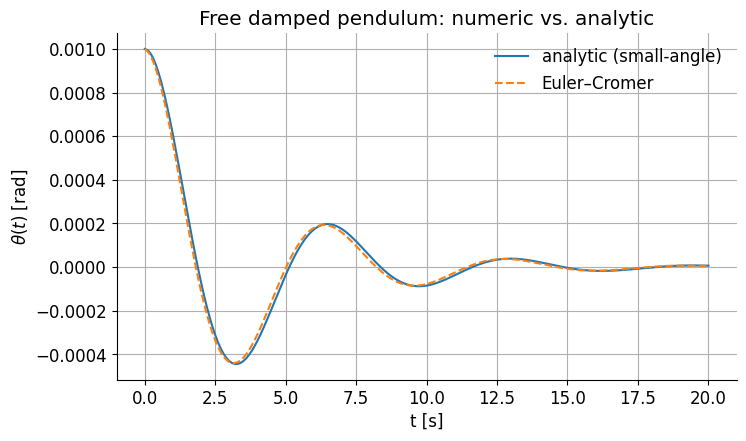

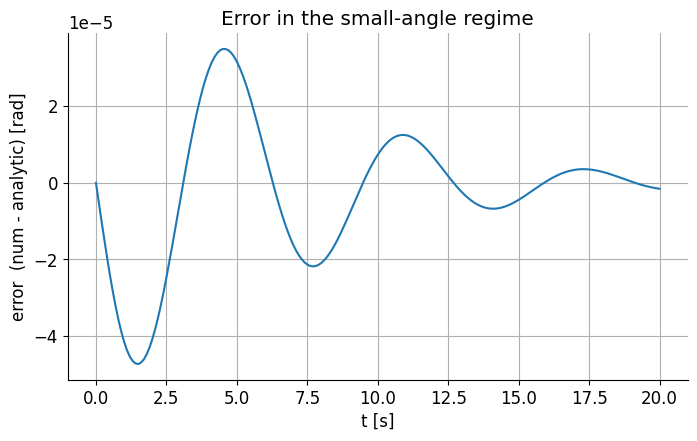

In [ ]:
# Definition of the linearised solution
def theta_linear(t: np.ndarray, Omega: float, q: float, theta0: float, omega0: float) -> np.ndarray:
    Omega1 = math.sqrt(max(Omega**2 - (q/2.0)**2, 0.0))
    return np.exp(-q*t/2.0) * (
        theta0 * np.cos(Omega1 * t) + ((omega0 + (q/2.0)*theta0)/Omega1) * np.sin(Omega1 * t)
    )

# Here we set the parameters and initial data
Omega, q, f, Omega_d = 1.0, 0.5, 0.0, 0.667
theta0, omega0 = 1e-3, 0.0  # small angle regime
dt, tmax = 1e-1, 20.0       # small dt for accuracy - but notice that a too small dt may imply longer running time!

# We then compute the numerical solution with the Euler-Cromer method
sol = integrate_euler_cromer(Omega, q, f, Omega_d, theta0, omega0, dt, tmax)
t = sol["t"]
theta_num = sol["theta_unwrapped"]  # use unwrapped for error analysis
theta_lin = theta_linear(t, Omega, q, theta0, omega0)

# ...and we compute the error of the numerical solution against the linearised solution
err = theta_num - theta_lin

# We can then plot the numerical and analytic solution
fig, ax = plt.subplots()
ax.plot(t, theta_lin, label="analytic (small-angle)")
ax.plot(t, theta_num, linestyle='--', label="Euler–Cromer")
ax.set_xlabel("t [s]")
ax.set_ylabel(r"$\theta(t)$ [rad]")
ax.set_title("Free damped pendulum: numeric vs. analytic")
ax.legend()
plt.show()

# ...and also plot the error
fig, ax = plt.subplots()
ax.plot(t, err)
ax.set_xlabel("t [s]")
ax.set_ylabel("error  (num - analytic) [rad]")
ax.set_title("Error in the small-angle regime")
plt.show()

## The driven response and transients

With a periodic drive force (per unit-mass) $f\sin(\Omega_d t)$ the system can show rich behaviour.
We should expect three main cases:
- a single steady periodic response at the drive frequency (after transients);
- **period‑doubling** cascades (namely, the motion repeats itself after 2, 3, 4,... periods $T_d$, with $T_d=\tfrac{2\pi}{\Omega_d}$ the period associated with the driving force);
- quasi‑periodicity or **chaos**.

Below, we set $\theta(0)=0$, $\omega(0)=0$. Then, we integrate for a **long time** so transients decay (hundreds of drive periods).


The period is 9.42


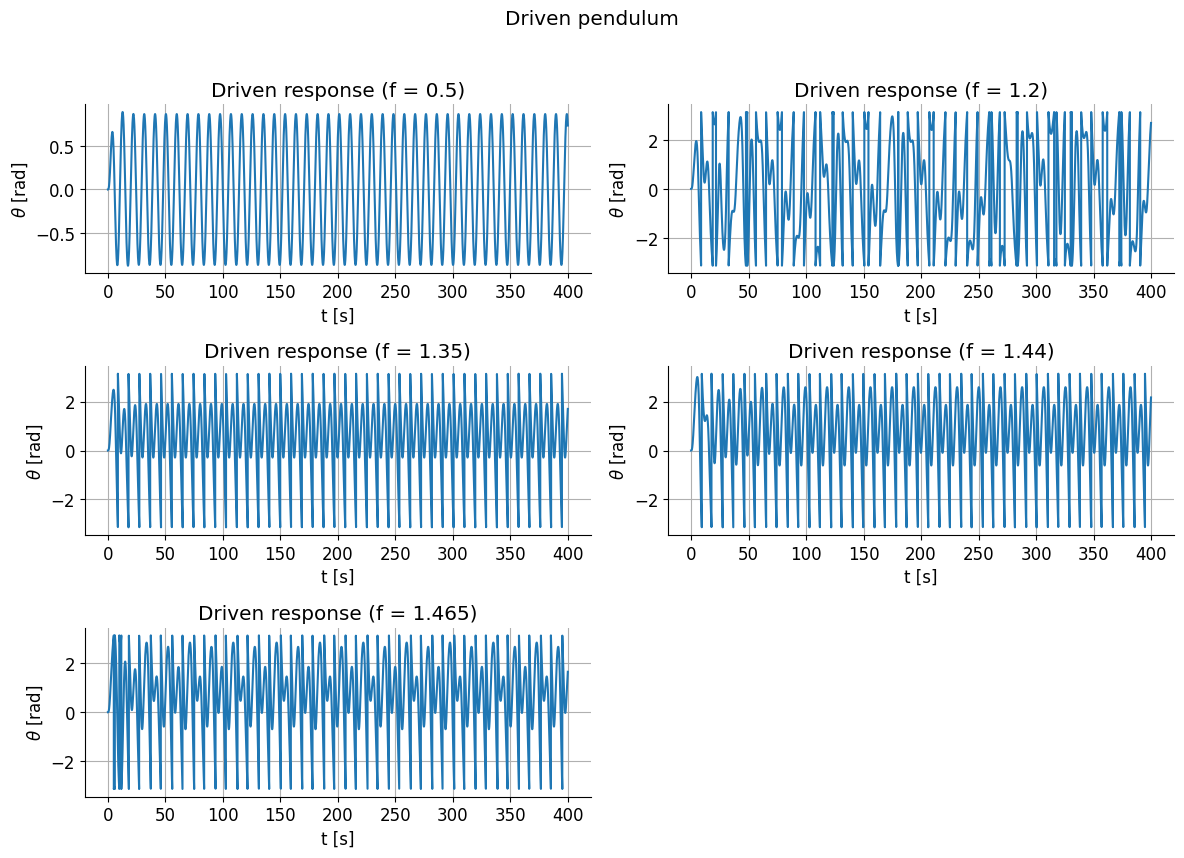

In [76]:
# Parameters and initial conditions

f_list = [0.5, 1.2, 1.35, 1.44, 1.465]

theta0 = 0.0
omega0 = 0.0

Omega = 1.0
q = 0.5
Omega_d = 2.0/3.0
Td = 2*np.pi/Omega_d 

# For convenience we also print the period
print("The period is {:.2f}".format(Td))

dt = 1e-2
tmax = 400.0  # long integration to pass the transient phase


ncols = 2
nrows = int(np.ceil(len(f_list)/ncols))

fig, axs = plt.subplots(nrows, ncols, figsize=(12, 2.8*nrows), squeeze=False)
axs = axs.flatten()

for i, f in enumerate(f_list):
    sol = integrate_euler_cromer(Omega, q, f, Omega_d, theta0, omega0, dt, tmax)
    t = sol["t"]
    theta_wrapped = sol["theta"]
    axs[i].plot(t, theta_wrapped)
    axs[i].set_title(f"Driven response (f = {f})")
    axs[i].set_xlabel("t [s]")
    axs[i].set_ylabel(r"$\theta$ [rad]")

# Hide any unused subplots
for j in range(i+1, len(axs)):
    axs[j].axis('off')

fig.suptitle("Driven pendulum", y=1.02)
fig.tight_layout()
plt.show()

## Stroboscopic sampling


The period associated with the driving force is $T_d=\tfrac{2\pi}{\Omega_d}$. 
The **stroboscopic map** is defined as
$$
\Theta_n = \theta(nT_d).
$$

We can then plot $\{\Theta_n\}$, varying $n$ (after skipping transients).
The interpretation of the scatter plot of $\{\Theta_n\}$ is the following:
- **One point** $\Rightarrow$ period‑1 motion (locked to the drive);
- **Two points** $\Rightarrow$ period‑2 (i.e. the period is 'doubled');
- (more in general) **Finite set** $\Rightarrow$ period‑$k$ (i.e. the period is $k$-times the drive period);
- **Dense set** $\Rightarrow$ chaos (namely, no periodic structure can be - easily - identified).

A code achieving this is the following:

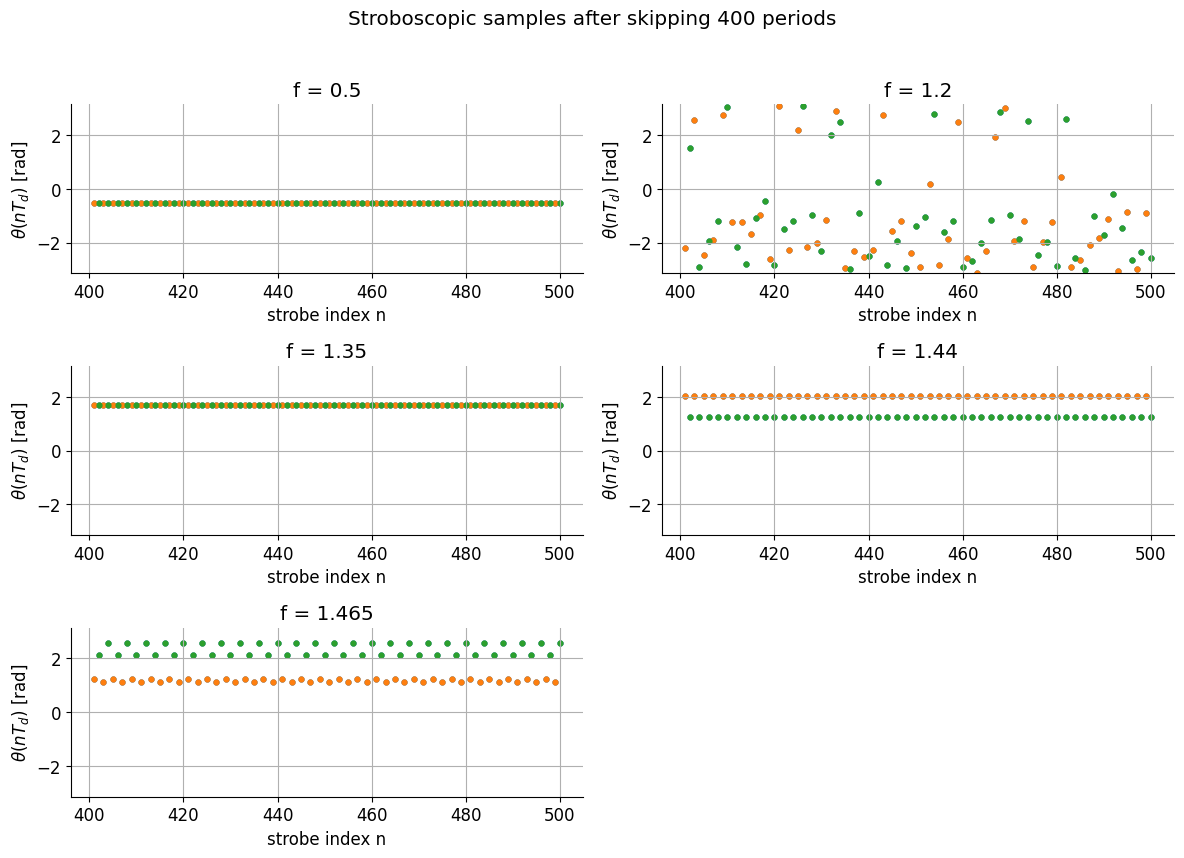

In [82]:
def strobe_sequence(t, theta_unwrapped, Td, n_start=1, n_take=100):
    """
    Returns (n, tn, Theta) where:
      n      = array of strobe indices
      tn     = n * Td (times)
      Theta  = wrapped θ(tn) in (-π, π]
    """
    n = np.arange(n_start, n_start + n_take)
    tn = n * Td
    # Interpolate the unwrapped angle at the exact strobe times, then wrap for display
    theta_interp = np.interp(tn, t, theta_unwrapped)
    Theta = (theta_interp + np.pi) % (2*np.pi) - np.pi
    return n, tn, Theta



# Parameters and initial conditions
Omega, q, Omega_d = 1.0, 0.5, 0.667
Td = 2*np.pi / Omega_d
f_list = [0.5, 1.2, 1.35, 1.44, 1.465]

theta0, omega0 = 0.0, 0.0
dt = 1e-2

# To "see" steady behaviour, we skip a long transient.
# If we want to include the transient phase, we set SKIP = 0.
SKIP = 400        # number of drive periods to skip before sampling
N_TAKE = 100      # we then collect n = SKIP+1 .. SKIP+100 (namely, we should be 'outside' the transient phase)

# We make sure we integrate long enough
tmax = (SKIP + N_TAKE + 10) * Td

ncols = 2
nrows = int(np.ceil(len(f_list) / ncols))
fig, axs = plt.subplots(nrows, ncols, figsize=(12, 2.8*nrows), squeeze=False)
axs = axs.flatten()

for i, f in enumerate(f_list):
    sol = integrate_euler_cromer(Omega, q, f, Omega_d, theta0, omega0, dt, tmax)
    n, tn, Theta = strobe_sequence(sol["t"], sol["theta_unwrapped"], Td,
                                   n_start=1+SKIP, n_take=N_TAKE)
    
    

    # Plot θ(n T_d) vs the strobe index n 
    axs[i].scatter(n, Theta, s=12)
    axs[i].set_title(r"f = {}".format(f))
    axs[i].set_xlabel("strobe index n")
    axs[i].set_ylabel(r"$\theta(n T_d)$ [rad]")
    axs[i].set_ylim([-np.pi, np.pi])

    # Label differently the even/odd n
    axs[i].scatter(n[::2], Theta[::2], s=12, label="even n")
    axs[i].scatter(n[1::2], Theta[1::2], s=12, label="odd n")
    #axs[i].legend(loc="best")


# Hide any unused axes
for j in range(i+1, len(axs)):
    axs[j].axis("off")

fig.suptitle(f"Stroboscopic samples after skipping {SKIP} periods", y=1.02)
fig.tight_layout()
plt.show()


Although this is not strictly necessary, one could also set up a code that counts the different levels, thus delivering the expected number of periods of the driven oscillatory solutions.
An example of such a code is the following:

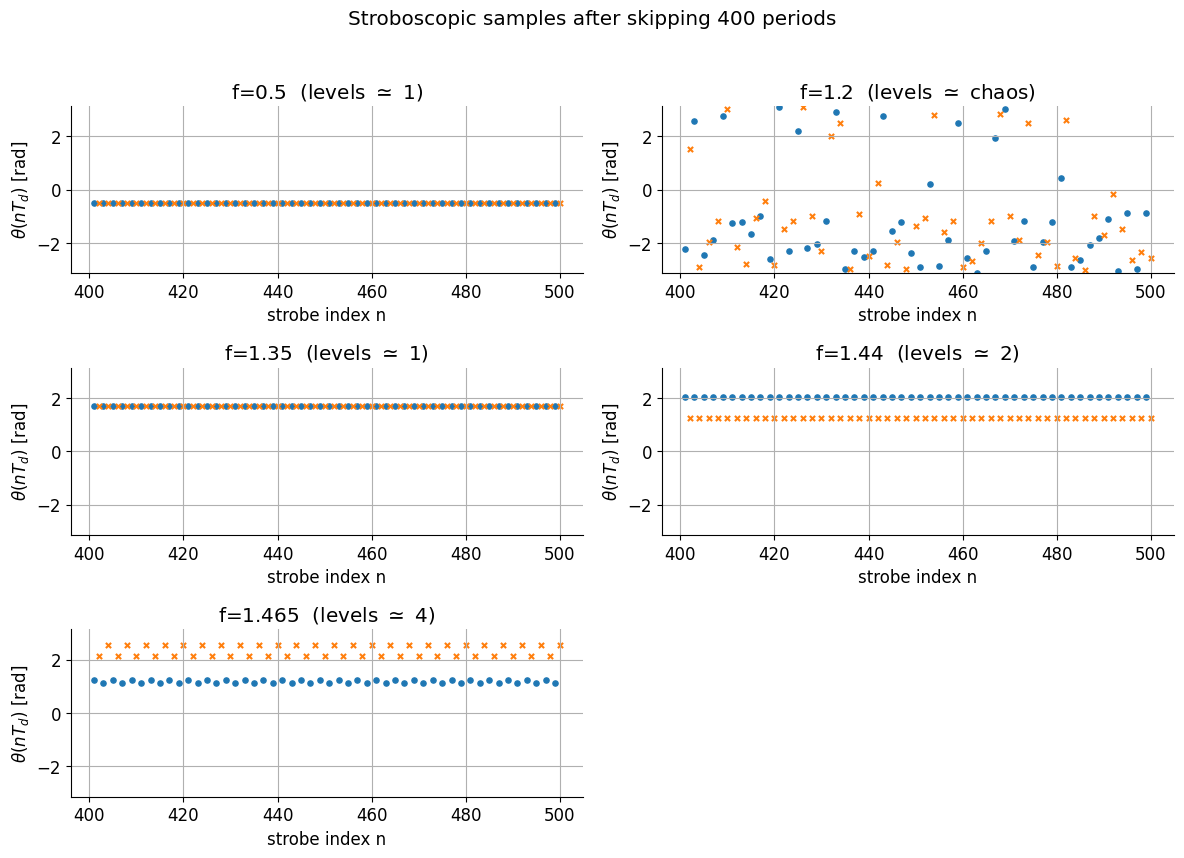

In [83]:
def count_strobe_levels(Theta, tol=0.05, max_k_for_chaos=6):
    """
    Count distinct strobe levels for angles in (-pi, pi], robust to wrap-around.
    tol is the angular clustering tolerance in radians (~0.05 ≈ 3 degrees).
    Returns (k or 'chaos' - in case k exceeds max_k_for_chaos, centers).
    """
    # Map to [0, 2π) and sort
    a = (Theta + np.pi) % (2*np.pi)
    a.sort()
    if len(a) == 0:
        return 0, np.array([])

    # Start after the largest gap so a cluster isn't split at the wrap boundary
    diffs = np.diff(np.r_[a, a[0] + 2*np.pi])
    start = (np.argmax(diffs) + 1) % len(a)
    a = np.r_[a[start:], a[:start]]

    # 1D clustering with threshold tol
    centers = [a[0]]
    for v in a[1:]:
        if v - centers[-1] > tol:
            centers.append(v)

    k = len(centers)
    # Convert centers back to (-π, π]
    centers = (np.array(centers) - np.pi + 2*np.pi) % (2*np.pi) - np.pi

    if k > max_k_for_chaos:
        return "chaos", centers
    return k, centers

# Parameters and initil conditions
Omega, q, Omega_d = 1.0, 0.5, 0.667
Td = 2*np.pi / Omega_d
f_list = [0.5, 1.2, 1.35, 1.44, 1.465]

theta0, omega0 = 0.0, 0.0
dt = 1e-2         # smaller step helps avoid artefacts
SKIP = 400          # skip this many periods (discard transients)
N_TAKE = 100        # take 100 strobe samples after the skip
tmax = (SKIP + N_TAKE + 10) * Td

# Plot
ncols = 2
nrows = int(np.ceil(len(f_list) / ncols))
fig, axs = plt.subplots(nrows, ncols, figsize=(12, 2.8*nrows), squeeze=False)
axs = axs.flatten()

for i, f in enumerate(f_list):
    sol = integrate_euler_cromer(Omega, q, f, Omega_d, theta0, omega0, dt, tmax)
    n, tn, Theta = strobe_sequence(sol["t"], sol["theta_unwrapped"], Td,
                                   n_start=1+SKIP, n_take=N_TAKE)

    # Count levels (period ≈ number of levels)
    k, centers = count_strobe_levels(Theta, tol=0.05)

    # Show points (color differently even vs odd)
    axs[i].scatter(n[::2],  Theta[::2],  s=14, label="even n")
    axs[i].scatter(n[1::2], Theta[1::2], s=14, marker='x', label="odd n")

    axs[i].set_title(r"f={}  (levels $\simeq$ {})".format(f,k))
    axs[i].set_xlabel("strobe index n")
    axs[i].set_ylabel(r"$\theta(n T_d)$ [rad]")
    axs[i].set_ylim([-np.pi, np.pi])
    # axs[i].legend(fontsize=8, frameon=False, loc="best")

# Hide unused axes
for j in range(i+1, len(axs)):
    axs[j].axis("off")

fig.suptitle(f"Stroboscopic samples after skipping {SKIP} periods", y=1.02)
fig.tight_layout()
plt.show()
